# TalkingData Kaggle competition

**Contest URL**: https://www.kaggle.com/c/talkingdata-mobile-user-demographics

**Background**: (taken from the above link):
Nothing is more comforting than being greeted by your favorite drink just as you walk through the door of the corner café. While a thoughtful barista knows you take a macchiato every Wednesday morning at 8:15, it’s much more difficult in a digital space for your preferred brands to personalize your experience.

TalkingData, China’s largest third-party mobile data platform, understands that everyday choices and behaviors paint a picture of who we are and what we value. Currently, TalkingData is seeking to leverage behavioral data from more than 70% of the 500 million mobile devices active daily in China to help its clients better understand and interact with their audiences.

In this competition, Kagglers are challenged to build a model predicting users’ demographic characteristics based on their app usage, geolocation, and mobile device properties. Doing so will help millions of developers and brand advertisers around the world pursue data-driven marketing efforts which are relevant to their users and catered to their preferences.

**Lots of code from the following Kaggle kernels is adapted and or applied verbatim:**
- https://www.kaggle.com/xiaoml/talkingdata-mobile-user-demographics/bag-of-app-id-python-2-27392/code
- https://www.kaggle.com/dvasyukova/talkingdata-mobile-user-demographics/a-linear-model-on-apps-and-labels
- https://www.kaggle.com/alexxanderlarko/talkingdata-mobile-user-demographics/bag-of-apps-keras-11-08-16

**Iteration on model parameters is tracked here:**
- https://docs.google.com/spreadsheets/d/1nA9Tmq4fGEN0941bnhjD_FHIily4ndXO89RrzGoBvLU/edit?usp=sharing

**My Kaggle profile:**
- https://www.kaggle.com/bgnipp

## Imports and data loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
now = datetime.datetime.now()
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

%matplotlib inline


print "Loading data..."
try:
    gatrain = pd.read_csv('input/gender_age_train.csv',
                      index_col='device_id')
    gatest = pd.read_csv('input/gender_age_test.csv',
                     index_col = 'device_id')
    phone = pd.read_csv('input/phone_brand_device_model.csv')
    # Get rid of duplicate device ids in phone
    phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
    
    events = pd.read_csv('input/events.csv',
                     parse_dates=['timestamp'], index_col='event_id')
    appevents = pd.read_csv('input/app_events.csv', 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
    applabels = pd.read_csv('input/app_labels.csv')
    print "Load succeeded!"
except:
    "Data load failed :("

Loading data...
Load succeeded!


## Exploration

Data schema (from Kaggle, with annotations I added)

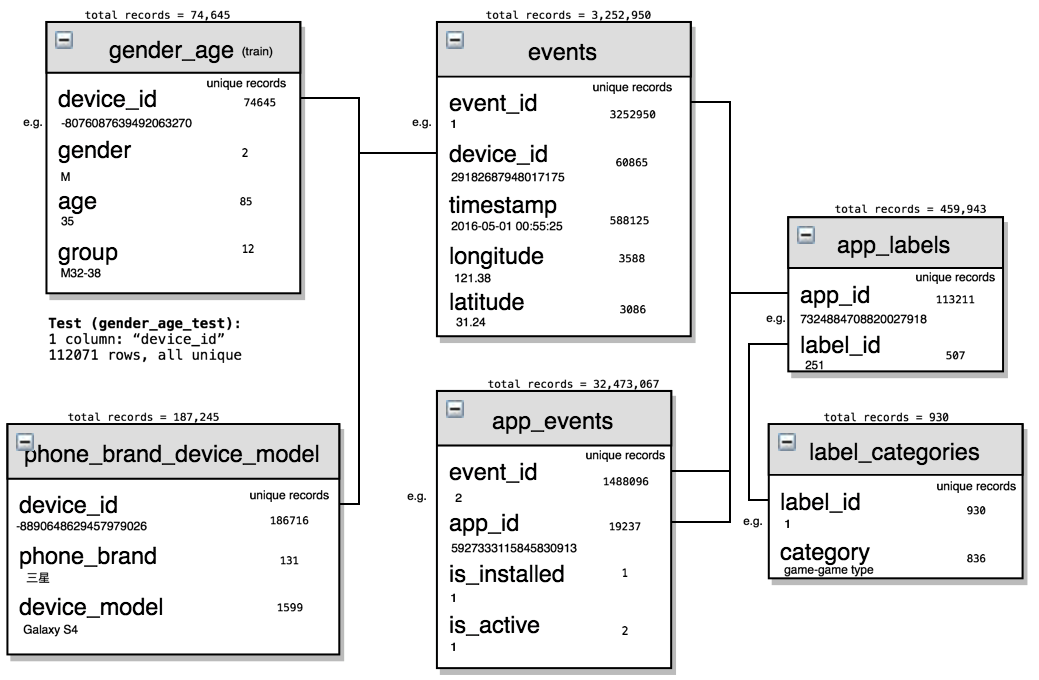

In [2]:
from IPython.display import Image
Image(filename='schema.png') 

**Data file heads**

In [3]:
gatrain.head(3)

,gender,age,group
device_id,,,
-8076087639492063270,M,35,M32-38
-2897161552818060146,M,35,M32-38
-8260683887967679142,M,35,M32-38


In [5]:
gatest.head(3)

""
device_id
1002079943728939269
-1547860181818787117
7374582448058474277


In [6]:
events.head(3)

,device_id,timestamp,longitude,latitude
event_id,,,,
1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70


In [7]:
applabels.head(3)

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406


In [112]:
phone.head(3)

,phone_brand,device_model,brand,model
device_id,,,,
-8890648629457979026,小米,红米,51,858
1277779817574759137,小米,MI 2,51,843
5137427614288105724,三星,Galaxy S4,15,371


In [113]:
phone.describe()

,brand,model
count,186716.000000,186716.000000
mean,44.516051,719.273485
std,37.601247,444.700024
min,0.000000,0.000000
25%,15.000000,348.000000
50%,31.000000,735.000000
75%,51.000000,863.000000
max,130.000000,1666.000000


In [9]:
appevents.head(3)

,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False


In [10]:
applabels.head(3)

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406


**Age/gender distribution (training set)**

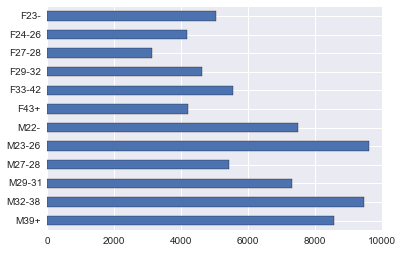

In [11]:
gatrain.group.value_counts().sort_index(ascending=False).plot(kind='barh')

**Observations**

- Most of the devices (in both training and test sets) have no events, so we must rely on phone brand/model for these
- All is_active values in the app_events data/table are the same, so we can disregard it
- The timestamps span a period of about a week.  Times are in UTC.
- Many latitude/longitude values are 0.0 (missing)
- The label_categories data/table simply provides a string identifier for each (numerically identified) label_id, so this is not useful for processing
- Refer to the feature engineering section below for further exploration/analysis



## Pre-processing
One hot encoding (in sparse matrix) for phone brand, device model, installed apps, and app labels

**Phone brand**

In [12]:
#create enumeration column (to mark which train/test set row device id's belong to) 
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

In [13]:
#encode phone.brand values
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])

#join phone.brand values on the train and test sets
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']

#one-hot sparse encoding of phone.brand values corresponding to test and train sets
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


**Device model**

In [14]:
#concatenate phone.device_id and phone.phone_brand, and encode the results
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)

#join the results on phone, test, and train dataframes
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']

#one-hot sparse encoding of phone.model values corresponding to test and train sets
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))

print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


**Installed apps**

In [15]:
#encode app_ids (in app_events table)
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)

#merge appevents table with corresponding device id's 
deviceapps = appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)

#group by device_id and app, and count the number of events corresponding to each app 
deviceapps = deviceapps.groupby(['device_id','app'])['app'].agg(['size'])

#for groups of device_id/app, merge with 'trainrow' and 'testrow' value
deviceapps = deviceapps.merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
deviceapps = deviceapps.merge(gatest[['testrow']], how='left', left_index=True, right_index=True)

deviceapps = deviceapps.reset_index()
deviceapps.head()

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594,NaN
1,-9222956879900151005,1096,18,21594,NaN
2,-9222956879900151005,1248,26,21594,NaN
3,-9222956879900151005,1545,12,21594,NaN
4,-9222956879900151005,1664,18,21594,NaN


In [16]:
#create subset of deviceapps for all rows w/ non NaN trainrow values
d = deviceapps.dropna(subset=['trainrow'])
#one-hot sparse encoding of app values corresponding trainrows
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
#non-one-hot spare encoding (number of occurances of app event, instead of app present true/false)
Xtr_app_sized = csr_matrix((d['size'], (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))

#same as above, but for testrows 
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
Xte_app_sized = csr_matrix((d['size'], (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))

print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


**App labels**

In [17]:
#drop all irrelevant rows from applabels (labels not related to appevents via app_id)
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]

#encode app_id
applabels['app'] = appencoder.transform(applabels.app_id)

#encode label id 
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)

In [18]:
#new df (columns = device_id, app, label), merging applabels and device apps
devicelabels = deviceapps[['device_id','app']].merge(applabels[['app','label']])

#group by device_id and label, and count the number of labels corresponding to each device 
devicelabels = devicelabels.groupby(['device_id','label'])['app'].agg(['size'])

#for groups of device_id/labels, merge with 'trainrow' and 'testrow' value
devicelabels = devicelabels.merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
devicelabels = devicelabels.merge(gatest[['testrow']], how='left', left_index=True, right_index=True)

devicelabels = devicelabels.reset_index()
devicelabels.head()

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,21594,NaN
1,-9222956879900151005,120,1,21594,NaN
2,-9222956879900151005,126,1,21594,NaN
3,-9222956879900151005,138,2,21594,NaN
4,-9222956879900151005,147,2,21594,NaN


In [19]:
#create subset of devicelabels for all rows w/ non NaN trainrow values
d = devicelabels.dropna(subset=['trainrow'])
#one-hot sparse encoding of label values corresponding trainrows
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
#non-one-hot spare encoding (number of occurances of label event, instead of label present true/false)
Xtr_label_sized = csr_matrix((d['size'], (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))

#same as above, but for testrows 
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))
Xte_label_sized = csr_matrix((d['size'], (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))

print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))

Labels data: train shape (74645, 492), test shape (112071, 492)


**Combine feature sparse matricies**

In [20]:
#with one-hot-encoded device and app attributes
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')

#with non-one-hot-encoded device and app attribtues (includes # of occurances for each)
Xtrain_sized = hstack((Xtr_brand, Xtr_model, Xtr_app_sized, Xtr_label_sized), format='csr')
Xtest_sized =  hstack((Xte_brand, Xte_model, Xte_app_sized, Xte_label_sized), format='csr')

print('Xtrain/Xtest: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

Xtrain/Xtest: train shape (74645, 21527), test shape (112071, 21527)


**Cross validation split**

In [21]:
#encode group (e.g. "M32-38") as target array 
targetencoder = LabelEncoder().fit(gatrain.group)
targetencoder2 = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

# Logistic regression

**Apply LR on one-hot-encoded (unsized) matricies**

In [22]:
#Apply classifier and return log loss 
def score(clf, random_state = 0):
    
    #create folds for labels (5 arrays, each consisting of 2 arrays, one train one validation)
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    
    #iterate through KFolds, fitting model and reporting log_loss
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        return log_loss(yte, pred[itest, :])
        print("{:.5f}".format(log_loss(yte, pred[itest,:])))
    print('')
    return log_loss(y, pred)

Find best value for regularization constant.
Lower values work better when there are more useless features.

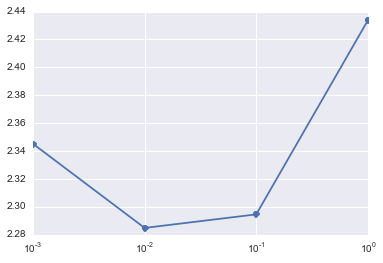

In [23]:
Cs = np.logspace(-3,0,4)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.semilogx(Cs, res,'-o');

In [24]:
score(LogisticRegression(C=0.01))

2.2848754908111539

In [25]:
score(LogisticRegression(C=0.02))

2.2797068319145302

In [26]:
score(LogisticRegression(C=0.03))

2.2796060625427796

In [27]:
score(LogisticRegression(C=0.05))

2.2828910116266314

Inspect CV score

In [28]:
# score(LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs'))

#added
lr_score = score(LogisticRegression(C=0.03))
lr_score

2.2796060625427796

Create dict and csv to track CV results

In [29]:
cv_results = {
    "LR": lr_score,
    "LRs": '',
    "NN": '',
    "NNs": '',
    "XGB": '',
    "XGBs": '',
    "bagXGB": '',
    "bagNN": ''
}

res_csv_name = 'output/results_' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
pd.Series(cv_results).to_csv(res_csv_name)

Apply to test data, produce CSV, create DF

In [30]:
# clf = LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs')

#added
clf = LogisticRegression(C=0.03)

clf.fit(Xtrain, y)
lr_pred_test = pd.DataFrame(clf.predict_proba(Xtest),
                            index = gatest.index, columns=targetencoder.classes_)

name = 'output/logreg_subm' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
lr_pred_test.to_csv(name,index=True)

LB score: 2.34543

Apply to train data, for subsequent stacking

In [31]:
lr_pred_train = pd.DataFrame(clf.predict_proba(Xtrain), index = gatrain.index, columns=targetencoder.classes_)

**Apply LR on non-one-hot-encoded (sized) matricies**

In [32]:
#Apply classifier and return log loss 
def score(clf, random_state = 0):
    
    #create folds for labels (5 arrays, each consisting of 2 arrays, one train one validation)
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    
    #iterate through KFolds, fitting model and reporting log_loss
    for itrain, itest in kf:
        Xtr, Xte = Xtrain_sized[itrain, :], Xtrain_sized[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        return log_loss(yte, pred[itest, :])
        print("{:.5f}".format(log_loss(yte, pred[itest,:])))
    print('')
    return log_loss(y, pred)

Find best value for regularization constant

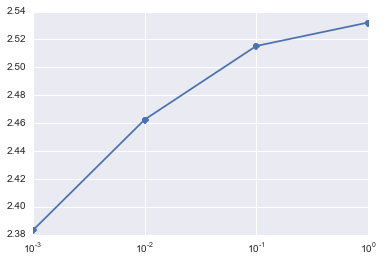

In [33]:
Cs = np.logspace(-3,0,4)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.semilogx(Cs, res,'-o');

In [34]:
score(LogisticRegression(C=0.001))

2.3832870965373405

In [35]:
score(LogisticRegression(C=0.002))

2.3980009083284068

In [36]:
score(LogisticRegression(C=0.003))

2.4123442631526362

In [37]:
score(LogisticRegression(C=0.005))

2.4367361216922969

Inspect CV score

In [38]:
# score(LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs'))

#added
LRs_score = score(LogisticRegression(C=0.03))

cv_results['LRs'] = LRs_score
pd.Series(cv_results).to_csv(res_csv_name)

Apply to test data, produce CSV

In [39]:
# clf = LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs')

#added
clf = LogisticRegression(C=0.03)

clf.fit(Xtrain, y)
lr_pred_test_sized = pd.DataFrame(clf.predict_proba(Xtest_sized), index = gatest.index, columns=targetencoder.classes_)

name = 'output/logreg_subm_sized' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
lr_pred_test_sized.to_csv(name,index=True)

LB score: 2.62504

Apply to train data, for subsequent stacking

In [40]:
lr_pred_train_sized = pd.DataFrame(clf.predict_proba(Xtrain_sized),
                                   index = gatrain.index, columns=targetencoder.classes_)

# Neural nets

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split

Using Theano backend.


In [42]:
#use sparse matricies w/ keras NN
#taken from kaggle user chenglong
#kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22567/neural-network-for-sparse-matrices

def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

In [43]:
def batch_generatorp(X, batch_size, shuffle):
    number_of_batches = X.shape[0] / np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    while True:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X[batch_index, :].toarray()
        counter += 1
        yield X_batch
        if (counter == number_of_batches):
            counter = 0

In [44]:
# define baseline model tanh sigmoid
def baseline_model():
    model = Sequential()
    #model.add(Dense(10, input_dim=Xtrain.shape[1], init='normal', activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(50, input_dim=Xtrain.shape[1], init='normal', activation='tanh'))
    model.add(Dropout(0.6))
    
    #just added
    model.add(Dense(20, init='normal', activation='sigmoid'))
    model.add(Dropout(0.5))
    
    
    model.add(Dense(12, init='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])  #logloss
    return model

In [45]:
#one-hot encode traing targets 
dummy_y = np_utils.to_categorical(y)
print "done"

done


**Train NN on non-one-hot-encoded (sized) matrix**

In [46]:
#Initialize keras sequential model 
model=baseline_model()

#test train split
X_train, X_val, y_train, y_val = train_test_split(Xtrain_sized, dummy_y, test_size=0.02, random_state=42)

fit= model.fit_generator(generator=batch_generator(X_train, y_train, 32, True),
                         nb_epoch=15,
                         samples_per_epoch=69984,
                         validation_data=(X_val.todense(), y_val), verbose=2
                         )

Epoch 1/15
40s - loss: 2.4334 - acc: 0.1265 - val_loss: 2.4253 - val_acc: 0.1433
Epoch 2/15
65s - loss: 2.4159 - acc: 0.1305 - val_loss: 2.4089 - val_acc: 0.1474
Epoch 3/15
78s - loss: 2.3982 - acc: 0.1383 - val_loss: 2.3899 - val_acc: 0.1433
Epoch 4/15
87s - loss: 2.3843 - acc: 0.1436 - val_loss: 2.3724 - val_acc: 0.1668
Epoch 5/15
90s - loss: 2.3719 - acc: 0.1508 - val_loss: 2.3587 - val_acc: 0.1661
Epoch 6/15
94s - loss: 2.3599 - acc: 0.1546 - val_loss: 2.3490 - val_acc: 0.1614
Epoch 7/15
94s - loss: 2.3570 - acc: 0.1570 - val_loss: 2.3423 - val_acc: 0.1715
Epoch 8/15
96s - loss: 2.3552 - acc: 0.1598 - val_loss: 2.3379 - val_acc: 0.1768
Epoch 9/15
96s - loss: 2.3507 - acc: 0.1627 - val_loss: 2.3379 - val_acc: 0.1755
Epoch 10/15
99s - loss: 2.3483 - acc: 0.1632 - val_loss: 2.3370 - val_acc: 0.1708
Epoch 11/15
99s - loss: 2.3443 - acc: 0.1679 - val_loss: 2.3342 - val_acc: 0.1815
Epoch 12/15
100s - loss: 2.3438 - acc: 0.1676 - val_loss: 2.3343 - val_acc: 0.1654
Epoch 13/15
98s - loss: 

Evaluate model

In [47]:
scores_val = model.predict_generator(generator=batch_generatorp(X_val, 32, False), val_samples=X_val.shape[0])
scores = model.predict_generator(generator=batch_generatorp(Xtest_sized, 32, False), val_samples=Xtest_sized.shape[0])

NN_score = log_loss(y_val, scores_val)
print('logloss val {}'.format(NN_score))

cv_results['NN'] = NN_score
pd.Series(cv_results).to_csv(res_csv_name)

logloss val 2.33333756304


Apply to test data, produce CSV

In [48]:
nn_pred_test_sized = pd.DataFrame(scores, index = gatest.index, columns=targetencoder.classes_)
name = 'output/nnet_keras_subm_sized' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
nn_pred_test_sized.to_csv(name,index=True)

LB score: 2.27335

Apply to train data, for subsequent stacking

In [49]:
scores_train = model.predict_generator(generator=batch_generatorp(Xtrain_sized,
                                                                  32, False), val_samples=Xtrain_sized.shape[0])
nn_pred_train_sized = pd.DataFrame(scores_train, index = gatrain.index, columns=targetencoder.classes_)

**Train NN on one-hot-encoded matrix (unsized)**

In [50]:
#Initialize keras sequential model 
model=baseline_model()

#test train split
X_train, X_val, y_train, y_val = train_test_split(Xtrain, dummy_y, test_size=0.02, random_state=42)

fit= model.fit_generator(generator=batch_generator(X_train, y_train, 32, True),
                         nb_epoch=15,
                         samples_per_epoch=69984,
                         validation_data=(X_val.todense(), y_val), verbose=2
                         )

Epoch 1/15
41s - loss: 2.4307 - acc: 0.1286 - val_loss: 2.4187 - val_acc: 0.1614
Epoch 2/15
66s - loss: 2.4041 - acc: 0.1351 - val_loss: 2.3916 - val_acc: 0.1608
Epoch 3/15
80s - loss: 2.3832 - acc: 0.1443 - val_loss: 2.3673 - val_acc: 0.1641
Epoch 4/15
86s - loss: 2.3655 - acc: 0.1533 - val_loss: 2.3470 - val_acc: 0.1648
Epoch 5/15
91s - loss: 2.3549 - acc: 0.1557 - val_loss: 2.3366 - val_acc: 0.1614
Epoch 6/15
92s - loss: 2.3503 - acc: 0.1588 - val_loss: 2.3308 - val_acc: 0.1601
Epoch 7/15
96s - loss: 2.3427 - acc: 0.1627 - val_loss: 2.3270 - val_acc: 0.1661
Epoch 8/15
94s - loss: 2.3408 - acc: 0.1634 - val_loss: 2.3250 - val_acc: 0.1648
Epoch 9/15
95s - loss: 2.3390 - acc: 0.1680 - val_loss: 2.3237 - val_acc: 0.1708
Epoch 10/15
95s - loss: 2.3325 - acc: 0.1706 - val_loss: 2.3224 - val_acc: 0.1695
Epoch 11/15
100s - loss: 2.3346 - acc: 0.1724 - val_loss: 2.3202 - val_acc: 0.1755
Epoch 12/15
97s - loss: 2.3299 - acc: 0.1736 - val_loss: 2.3201 - val_acc: 0.1849
Epoch 13/15
99s - loss: 

Evaluate model

In [51]:
scores_val = model.predict_generator(generator=batch_generatorp(X_val, 32, False), val_samples=X_val.shape[0])
scores = model.predict_generator(generator=batch_generatorp(Xtest, 32, False), val_samples=Xtest.shape[0])

NNs_score = log_loss(y_val, scores_val)
print('logloss val {}'.format(NNs_score))

cv_results['NNs'] = NNs_score
pd.Series(cv_results).to_csv(res_csv_name)

logloss val 2.3161335972


Apply to test data, produce CSV

In [52]:
nn_pred_test = pd.DataFrame(scores, index = gatest.index, columns=targetencoder.classes_)
name = 'output/nnet_keras_subm' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
nn_pred_test.to_csv(name,index=True)

LB score: 2.25468

Apply to train data, for subsequent stacking

In [53]:
scores_train = model.predict_generator(generator=batch_generatorp(Xtrain, 32, False), val_samples=Xtrain.shape[0])
nn_pred_train = pd.DataFrame(scores_train,
                             index = gatrain.index, columns=targetencoder.classes_)

# XGBoost

In [54]:
import xgboost as xgb
from sklearn.feature_selection import SelectPercentile, f_classif, chi2

**Train on one-hot-encoded (unsized) matrix**

Cross validation split

In [55]:
X_train, X_val, y_train, y_val = train_test_split(
    Xtrain, y, train_size=.90, random_state=10)

Feature selection

In [56]:
#apply SelectPercentile feature selector to dispose of less useful features
#(keep 80%, the most useful)
selector = SelectPercentile(f_classif, percentile=80)
selector.fit(X_train, y_train)

X_train = selector.transform(X_train)
X_val = selector.transform(X_val)

train_sp = selector.transform(Xtrain)
test_sp = selector.transform(Xtest)

print("# Num of Features: ", X_train.shape[1])

('# Num of Features: ', 17221)


/Users/bgnipp/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)


Train model

In [57]:
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_val, y_val)

params = {
    "objective": "multi:softprob",
    "num_class": 12,
    "booster": "gblinear",
    #changed from 6 to 4
    "max_depth": 4,
    "eval_metric": "mlogloss",
    "eta": 0.07,
    "silent": 1,
    "alpha": 3,
}

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, 40, evals=watchlist,
                early_stopping_rounds=25, verbose_eval=True)

print("# Train")
dtrain = xgb.DMatrix(train_sp, y)
gbm = xgb.train(params, dtrain, 40, verbose_eval=True)

Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.397537	eval-mlogloss:2.409104
[1]	train-mlogloss:2.358409	eval-mlogloss:2.377075
[2]	train-mlogloss:2.331682	eval-mlogloss:2.356239
[3]	train-mlogloss:2.311361	eval-mlogloss:2.341186
[4]	train-mlogloss:2.295143	eval-mlogloss:2.329665
[5]	train-mlogloss:2.281706	eval-mlogloss:2.320530
[6]	train-mlogloss:2.270372	eval-mlogloss:2.313122
[7]	train-mlogloss:2.260509	eval-mlogloss:2.307011
[8]	train-mlogloss:2.251991	eval-mlogloss:2.301907
[9]	train-mlogloss:2.244448	eval-mlogloss:2.297613
[10]	train-mlogloss:2.237720	eval-mlogloss:2.293966
[11]	train-mlogloss:2.231742	eval-mlogloss:2.290860
[12]	train-mlogloss:2.226322	eval-mlogloss:2.288203
[13]	train-mlogloss:2.221426	eval-mlogloss:2.285913
[14]	train-mlogloss:2.216991	eval-mlogloss:2.283947
[15]	train-mlogloss:2.212941	eval-mlogloss:2.282250
[16]	train-mlogloss:2.209210	eval-mlogloss:2.280787
[17]	train-mlogloss:2.205818	eval-mlogloss:2.279537
[18]	train-mlog

# Train


[39]	train-mlogloss:2.168655	eval-mlogloss:2.273506


Apply to test data, write to CSV

In [58]:
y_pre = gbm.predict(xgb.DMatrix(test_sp))
xgb_pred_test = pd.DataFrame(y_pre, columns=targetencoder.classes_)

device_id_test = gatest.index.values
xgb_pred_test["device_id"] = device_id_test
xgb_pred_test = xgb_pred_test.set_index("device_id")

name = 'output/xgb_test' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
xgb_pred_test.to_csv(name)

LB score: 2.26673

Apply to train data, for subsequent stacking

In [59]:
y_pre = gbm.predict(xgb.DMatrix(train_sp))
xgb_pred_train = pd.DataFrame(y_pre, columns=targetencoder.classes_)

device_id_train = gatrain.index.values
xgb_pred_train["device_id"] = device_id_train
xgb_pred_train = xgb_pred_train.set_index("device_id")

Record CV score

In [60]:
y_val_pre = gbm.predict(xgb.DMatrix(X_val))
XGB_score = log_loss(y_val.tolist(), y_val_pre)
print XGB_score

cv_results['XGB'] = XGB_score
pd.Series(cv_results).to_csv(res_csv_name)

2.16968605618


**Train on non-one-hot-encoded (sized) matrix**

In [61]:
X_train, X_val, y_train, y_val = train_test_split(
    Xtrain_sized, y, train_size=.90, random_state=10)

Feature selection

In [62]:
#apply SelectPercentile feature selector to dispose of less useful features
#(keep 80%, the most useful)
selector = SelectPercentile(f_classif, percentile=80)

selector.fit(X_train, y_train)

X_train = selector.transform(X_train)
X_val = selector.transform(X_val)

train_sp = selector.transform(Xtrain_sized)
test_sp = selector.transform(Xtest_sized)

print("# Num of Features: ", X_train.shape[1])

('# Num of Features: ', 17221)


Train model

In [63]:
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_val, y_val)

params = {
    "objective": "multi:softprob",
    "num_class": 12,
    "booster": "gblinear",
    #changed from 6 to 4
    "max_depth": 4,
    "eval_metric": "mlogloss",
    "eta": 0.07,
    "silent": 1,
    "alpha": 3,
}

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, 40, evals=watchlist,
                early_stopping_rounds=25, verbose_eval=True)

print("# Train")
dtrain = xgb.DMatrix(train_sp, y)
gbm = xgb.train(params, dtrain, 40, verbose_eval=True)

Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.386277	eval-mlogloss:2.428997
[1]	train-mlogloss:2.336755	eval-mlogloss:2.403608
[2]	train-mlogloss:2.301312	eval-mlogloss:2.387516
[3]	train-mlogloss:2.273336	eval-mlogloss:2.376368
[4]	train-mlogloss:2.250196	eval-mlogloss:2.368332
[5]	train-mlogloss:2.230620	eval-mlogloss:2.362479
[6]	train-mlogloss:2.213794	eval-mlogloss:2.358221
[7]	train-mlogloss:2.198946	eval-mlogloss:2.355135
[8]	train-mlogloss:2.185874	eval-mlogloss:2.352957
[9]	train-mlogloss:2.174186	eval-mlogloss:2.351604
[10]	train-mlogloss:2.163640	eval-mlogloss:2.350917
[11]	train-mlogloss:2.154050	eval-mlogloss:2.350770
[12]	train-mlogloss:2.145355	eval-mlogloss:2.351014
[13]	train-mlogloss:2.137412	eval-mlogloss:2.351410
[14]	train-mlogloss:2.129997	eval-mlogloss:2.352147
[15]	train-mlogloss:2.123227	eval-mlogloss:2.353144
[16]	train-mlogloss:2.116957	eval-mlogloss:2.354368
[17]	train-mlogloss:2.111094	eval-mlogloss:2.355792
[18]	train-mlog

# Train


Stopping. Best iteration:
[11]	train-mlogloss:2.154050	eval-mlogloss:2.350770



Apply to test data, write to CSV

In [64]:
y_pre = gbm.predict(xgb.DMatrix(test_sp))
xgb_pred_test_sized = pd.DataFrame(y_pre, columns=targetencoder.classes_)

device_id_test = gatest.index.values
xgb_pred_test_sized["device_id"] = device_id_test
xgb_pred_test_sized = xgb_pred_test_sized.set_index("device_id")

name = 'output/xgb_test_sized' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
xgb_pred_test_sized.to_csv(name)

LB score: 2.41950

Apply to train data, for subsequent stacking

In [65]:
y_pre = gbm.predict(xgb.DMatrix(train_sp))
xgb_pred_train_sized = pd.DataFrame(y_pre, columns=targetencoder.classes_)

device_id_train = gatrain.index.values
xgb_pred_train_sized["device_id"] = device_id_train
xgb_pred_train_sized = xgb_pred_train_sized.set_index("device_id")

Record CV score

In [66]:
y_val_pre = gbm.predict(xgb.DMatrix(X_val))
XGBs_score = log_loss(y_val.tolist(), y_val_pre)
print XGBs_score

cv_results['XGBs'] = XGBs_score
pd.Series(cv_results).to_csv(res_csv_name)

2.0498315373


## Engineer additional features (for stacking w/ output of first model)

**Location features**
- Mean lat/long
- Range of lat/long (max - min)
- Std dev of lat/long

In [67]:
#PRE-PROCESSED - load from CSV
loc_features = pd.read_csv('preprocessed/loc_features.csv')
loc_features = loc_features.set_index('device_id')
loc_features.head(3)

# #reload events
# events = pd.read_csv("input/events.csv", dtype={'device_id': np.str}, parse_dates=['timestamp'])

# #drop events without lat/long
# events = events[(events.latitude != 0) & (events.longitude != 0)]

# #compute average lat/long for each device ID:
# unique_devices = pd.DataFrame(index=events['device_id'].unique())

# lat_mean = []
# long_mean = []
# lat_range = []
# long_range = []
# lat_std = []
# long_std = []

# x = 0
# for dev in unique_devices.index:
#     evs = events[events.device_id == dev]
#     lat_mean.append(evs.latitude.values.mean())
#     long_mean.append(evs.longitude.values.mean())
#     lat_range.append(evs.latitude.values.max() - events[events.device_id == dev].latitude.values.min())
#     long_range.append(evs.longitude.values.max() - events[events.device_id == dev].longitude.values.min())
#     lat_std.append(evs.latitude.values.std())
#     long_std.append(evs.longitude.values.std())
#     x+= 1
#     if x % 100 == 0:
#         print "%s out of %s" % (str(x/100), len(unique_devices))

# unique_devices['lat_mean'] = lat_mean
# unique_devices['long_mean'] = long_mean
# unique_devices['lat_range'] = lat_range
# unique_devices['long_range'] = long_range
# unique_devices['lat_std'] = lat_std
# unique_devices['long_std'] = long_std

# unique_devices.index.name = 'device_id'
# unique_devices.to_csv('loc_features.csv')
# unique_devices.head(10)

,lat_mean,long_mean,lat_range,long_range,lat_std,long_std
device_id,,,,,,
29182687948017175,31.232593,121.375473,0.25,0.23,0.040178,0.037308
-6401643145415154744,30.003793,104.237241,11.26,6.93,3.155578,1.938973
-4833982096941402721,29.766364,106.813209,0.14,0.49,0.065043,0.211385


**Time features**
- Distribution of events across days of the week
- Distribution of events across hours of the day (split into 4 hour buckets)
- Binary distribution of events: halves of the day and week 
- Day and hour medians, .25 quantile, and .75 quantile
- Standard deviation of days (measure of dispersion of events across days)
- Standard deviation of hours (measure of dispersion of events across hours)

In [68]:
#PRE-PROCESSED - load from CSV
time_features = pd.read_csv('preprocessed/time_features.csv')
time_features = time_features.set_index('device_id')
time_features.head(3)

# #reload events
# events = pd.read_csv("input/events.csv", dtype={'device_id': np.str}, parse_dates=['timestamp'])

# #extract hour and day from timestamp
# events['hour'] = events.timestamp.dt.hour
# events['day'] = events.timestamp.dt.day
# events = events.drop(['timestamp', 'longitude', 'latitude'], axis=1)

# #compute hour and day std dev, and distribution of events across days, and 4 hour increments
# unique_devices2 = pd.DataFrame(index=events['device_id'].unique())

# hour_std = []
# day_std = []
# day30 = []
# day1 = []
# day2 = []
# day3 = []
# day4 = []
# day5 = []
# day6 = []
# day7 = []
# day8 = []
# day_hlf_1 = []
# day_hlf_2 = []
# day_qnt_25 = []
# day_qnt_50 = []
# day_qnt_75 = []
# hour3 = []
# hour7 = []
# hour11 = []
# hour15 = []
# hour19 = []
# hour23 = []
# hr_hlf_1 = []
# hr_hlf_2 = []
# hr_qnt_25 = []
# hr_qnt_50 = []
# hr_qnt_75 = []

# x = 0
# for dev in unique_devices2.index:
#     evs = events[events.device_id == dev]

#     if len(evs) != 0:
#         hour_std.append(evs.hour.values.std())
#         day_std.append(evs.day.values.std())

#         day30.append(len(evs.day[evs.day == 30])/float(len(evs)))
#         day1.append(len(evs.day[evs.day == 1])/float(len(evs)))
#         day2.append(len(evs.day[evs.day == 2])/float(len(evs)))
#         day3.append(len(evs.day[evs.day == 3])/float(len(evs)))
#         day4.append(len(evs.day[evs.day == 4])/float(len(evs)))
#         day5.append(len(evs.day[evs.day == 5])/float(len(evs)))
#         day6.append(len(evs.day[evs.day == 6])/float(len(evs)))
#         day7.append(len(evs.day[evs.day == 7])/float(len(evs)))
#         day8.append(len(evs.day[evs.day == 8])/float(len(evs)))
#         day_hlf_1.append(len(evs.day[(evs.day == 30) | (evs.day == 1) | (evs.day == 2) | (evs.day == 3) |
#                                     (evs.day == 4)])/float(len(evs)))
#         day_hlf_2.append(len(evs.day[(evs.day == 5) | (evs.day == 6) | (evs.day == 7) | (evs.day == 8)])/float(len(evs)))
#         day_qnt_25 = evs.day.quantile(q=.25)
#         day_qnt_50 = evs.day.quantile(q=.5)
#         day_qnt_75 = evs.day.quantile(q=.75)

#         hour3.append((len(evs.hour[(evs.hour == 0) | (evs.hour == 1) | (evs.hour == 2) | (evs.hour == 3)]))/float(len(evs)))
#         hour7.append((len(evs.hour[(evs.hour == 4) | (evs.hour == 5) | (evs.hour == 6) | (evs.hour == 7)]))/float(len(evs)))
#         hour11.append((len(evs.hour[(evs.hour == 8) | (evs.hour == 9) | (evs.hour == 10) | (evs.hour == 11)]))/float(len(evs)))
#         hour15.append((len(evs.hour[(evs.hour == 12) | (evs.hour == 13) | (evs.hour == 14) | (evs.hour == 15)]))/float(len(evs)))
#         hour19.append((len(evs.hour[(evs.hour == 16) | (evs.hour == 17) | (evs.hour == 18) | (evs.hour == 19)]))/float(len(evs)))
#         hour23.append((len(evs.hour[(evs.hour == 20) | (evs.hour == 21) | (evs.hour == 22) | (evs.hour == 23)]))/float(len(evs)))
#         hr_hlf_1.append((len(evs.hour[(evs.hour == 0) | (evs.hour == 1) | (evs.hour == 2) | (evs.hour == 3) |
#                                             (evs.hour == 4) | (evs.hour == 5) | (evs.hour == 6) | (evs.hour == 7) |
#                                             (evs.hour == 8) | (evs.hour == 9) | (evs.hour == 10) | (evs.hour == 11)
#                                             ]))/float(len(evs)))
#         hr_hlf_2.append((len(evs.hour[(evs.hour == 12) | (evs.hour == 13) | (evs.hour == 14) | (evs.hour == 15) |
#                                             (evs.hour == 16) | (evs.hour == 17) | (evs.hour == 18) | (evs.hour == 19) |
#                                             (evs.hour == 20) | (evs.hour == 21) | (evs.hour == 22) | (evs.hour == 23)
#                                             ]))/float(len(evs)))
#         hr_qnt_25 = evs.hour.quantile(q=.25)
#         hr_qnt_50 = evs.hour.quantile(q=.5)
#         hr_qnt_75 = evs.hour.quantile(q=.75)
        
#     else: 
#         hour_std.append(np.nan)
#         day_std.append(np.nan)
#         day30.append(np.nan)
#         day1.append(np.nan)
#         day2.append(np.nan)
#         day3.append(np.nan)
#         day4.append(np.nan)
#         day5.append(np.nan)
#         day6.append(np.nan)
#         day7.append(np.nan)
#         day8.append(np.nan)
#         day_hlf_1.append(np.nan)
#         day_hlf_2.append(np.nan)
#         day_qnt_25.append(np.nan)
#         day_qnt_50.append(np.nan)
#         day_qnt_75.append(np.nan)
#         hour3.append(np.nan)
#         hour7.append(np.nan)
#         hour11.append(np.nan)
#         hour15.append(np.nan)
#         hour19.append(np.nan)
#         hour23.append(np.nan)
#         hr_hlf_1.append(np.nan)
#         hr_hlf_2.append(np.nan)
#         hr_qnt_25.append(np.nan)
#         hr_qnt_50.append(np.nan)
#         hr_qnt_75.append(np.nan)

#     x+= 1
#     if x % 100 == 0:
#         print "%s out of %s" % (x, len(unique_devices2))
    
# unique_devices2['hour_std'] = hour_std
# unique_devices2['day_std'] = day_std
# unique_devices2['day30'] = day30
# unique_devices2['day1'] = day1
# unique_devices2['day2'] = day2
# unique_devices2['day3'] = day3
# unique_devices2['day4'] = day4
# unique_devices2['day5'] = day5
# unique_devices2['day6'] = day6
# unique_devices2['day7'] = day7
# unique_devices2['day8'] = day8
# unique_devices2['day_hlf_1'] = day_hlf_1
# unique_devices2['day_hlf_2'] = day_hlf_2
# unique_devices2['day_qnt_25'] = day_qnt_25
# unique_devices2['day_qnt_50'] = day_qnt_50
# unique_devices2['day_qnt_75'] = day_qnt_75
# unique_devices2['hour3'] = hour3
# unique_devices2['hour7'] = hour7
# unique_devices2['hour11'] = hour11
# unique_devices2['hour15'] = hour15
# unique_devices2['hour19'] = hour19
# unique_devices2['hour23'] = hour23
# unique_devices2['hr_hlf_1'] = hr_hlf_1
# unique_devices2['hr_hlf_2'] = hr_hlf_2
# unique_devices2['hr_qnt_25'] = hr_qnt_25
# unique_devices2['hr_qnt_50'] = hr_qnt_50
# unique_devices2['hr_qnt_75'] = hr_qnt_75

# unique_devices2.index.name = 'device_id'
# unique_devices2.to_csv('time_features.csv')

,hour_std,day_std,day30,day1,day2,day3,day4,day5,day6,day7,...,hour7,hour11,hour15,hour19,hour23,hr_hlf_1,hr_hlf_2,hr_qnt_25,hr_qnt_50,hr_qnt_75
device_id,,,,,,,,,,,,,,,,,,,,,
29182687948017175,6.823524,2.175960,0,0.242188,0.207031,0.078125,0.078125,0.082031,0.214844,0.097656,...,0.308594,0.156250,0.074219,0.105469,0.125000,0.695312,0.304688,23,23,23
-6401643145415154744,6.817928,1.276695,0,0.534247,0.164384,0.150685,0.082192,0.068493,0.000000,0.000000,...,0.027397,0.219178,0.205479,0.246575,0.082192,0.465753,0.534247,23,23,23
-4833982096941402721,5.369368,1.826341,0,0.169355,0.169355,0.157258,0.185484,0.141129,0.112903,0.064516,...,0.040323,0.302419,0.241935,0.201613,0.161290,0.395161,0.604839,23,23,23


Event count for each device ID

In [69]:
#reload events
events = pd.read_csv("input/events.csv", parse_dates=['timestamp'])

#count number of occurances of each unique device_id
ev_count = events.drop(['timestamp', 'longitude', 'latitude','event_id'], axis=1)
ev_count['device_id_size'] = ev_count.device_id
ev_count = ev_count.groupby(['device_id']).agg(['size'])
ev_count['total_ev'] = ev_count[('device_id_size', 'size')]

**Assess time/location feature importance**

Build dataframe (on training set) with features and targets

In [70]:
ag_feats_tr = nn_pred_train.merge(time_features, how='left', left_index=True, right_index=True)
ag_feats_tr = ag_feats_tr.merge(loc_features, how='left', left_index=True, right_index=True)
ag_feats_tr['ev_count'] = ev_count['total_ev']

#drop non-feature columns from ag_feats_tr
features_train = ag_feats_tr.drop(ag_feats_tr.columns[[0,1,2,3,4,5,6,7,8,9,10,11]],axis=1)

print features_train.columns.values

['hour_std' 'day_std' 'day30' 'day1' 'day2' 'day3' 'day4' 'day5' 'day6'
 'day7' 'day8' 'day_hlf_1' 'day_hlf_2' 'day_qnt_25' 'day_qnt_50'
 'day_qnt_75' 'hour3' 'hour7' 'hour11' 'hour15' 'hour19' 'hour23'
 'hr_hlf_1' 'hr_hlf_2' 'hr_qnt_25' 'hr_qnt_50' 'hr_qnt_75' 'lat_mean'
 'long_mean' 'lat_range' 'long_range' 'lat_std' 'long_std' 'ev_count']


Train xgboost model to assess feature importance

In [71]:
X_train, X_val, y_train, y_val = train_test_split(
    features_train, y, train_size=.90, random_state=10)

dtrain = xgb.DMatrix(X_train, y_train, missing=np.nan)
dvalid = xgb.DMatrix(X_val, y_val, missing=np.nan)

params = {
    "objective": "multi:softprob",
    "num_class": 12,
    "booster": "gbtree",
    #changed from 6 to 4
    "max_depth": 4,
    "eval_metric": "mlogloss",
    #learning rate, default = .3, typical final values 0.01 - .2
    "eta": 0.1,
    "silent": 1,
}

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, 40, evals=watchlist,
                early_stopping_rounds=25, verbose_eval=True)

dtrain = xgb.DMatrix(features_train, y, missing=np.nan)
gbm = xgb.train(params, dtrain, 40, verbose_eval=True)

print "complete"

Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.476260	eval-mlogloss:2.477683
[1]	train-mlogloss:2.467884	eval-mlogloss:2.471232
[2]	train-mlogloss:2.460933	eval-mlogloss:2.465540
[3]	train-mlogloss:2.454966	eval-mlogloss:2.460409
[4]	train-mlogloss:2.448807	eval-mlogloss:2.455981
[5]	train-mlogloss:2.443739	eval-mlogloss:2.452096
[6]	train-mlogloss:2.439017	eval-mlogloss:2.448563
[7]	train-mlogloss:2.434574	eval-mlogloss:2.445369
[8]	train-mlogloss:2.431282	eval-mlogloss:2.442568
[9]	train-mlogloss:2.427189	eval-mlogloss:2.440022
[10]	train-mlogloss:2.424070	eval-mlogloss:2.437908
[11]	train-mlogloss:2.420707	eval-mlogloss:2.435872
[12]	train-mlogloss:2.418071	eval-mlogloss:2.434129
[13]	train-mlogloss:2.415903	eval-mlogloss:2.432602
[14]	train-mlogloss:2.413091	eval-mlogloss:2.431228
[15]	train-mlogloss:2.411071	eval-mlogloss:2.430033
[16]	train-mlogloss:2.408380	eval-mlogloss:2.428831
[17]	train-mlogloss:2.407219	eval-mlogloss:2.427766
[18]	train-mlog

complete


[39]	train-mlogloss:2.381297	eval-mlogloss:2.420175


Plot feature importance

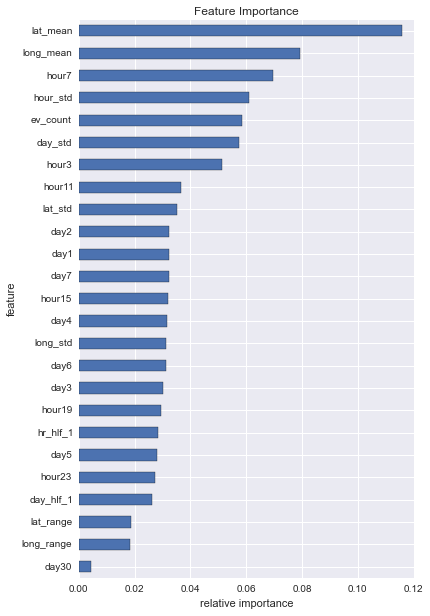

In [72]:
import operator
from matplotlib import pylab as plt

importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

feat_importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
feat_importance_df['fscore'] = feat_importance_df['fscore'] / feat_importance_df['fscore'].sum()

feat_importance_df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [73]:
feat_importance_df = feat_importance_df.sort_values('fscore',ascending=False)
feat_importance_df

,feature,fscore
24,lat_mean,0.115965
23,long_mean,0.079314
22,hour7,0.069638
21,hour_std,0.061135
20,ev_count,0.058642
19,day_std,0.057616
18,hour3,0.051312
17,hour11,0.036505
16,lat_std,0.035332
15,day2,0.032400


## Aggregate features (for stacking) 

Merge new features with output of prior model (NN - unsized)

In [74]:
#merge new features 
ag_feats_tr = nn_pred_train.merge(time_features, how='left', left_index=True, right_index=True)
ag_feats_tr = ag_feats_tr.merge(loc_features, how='left', left_index=True, right_index=True)
ag_feats_tr['ev_count'] = ev_count['total_ev']

ag_feats_te = nn_pred_test.merge(time_features, how='left', left_index=True, right_index=True)
ag_feats_te = ag_feats_te.merge(loc_features, how='left', left_index=True, right_index=True)
ag_feats_te['ev_count'] = ev_count['total_ev']

#drop less useful features (per analysis above)
discard_features = ['hour11','day6','day4','hour19','day5','hr_hlf_1','hour15','day7','lat_range',
                   'hour23','day_hlf_1','long_range','day30']
ag_feats_tr = ag_feats_tr.drop(discard_features, axis=1)
ag_feats_te = ag_feats_te.drop(discard_features, axis=1)

In [75]:
#rename columns headers, for data from nn_pred_train and nn_pred_test
ag_feats_tr.columns.values[0:12] = ['F23-nn', 'F24-26nn', 'F27-28nn', 'F29-32nn', 'F33-42nn', 'F43+nn', 'M22-nn',
       'M23-26nn', 'M27-28nn', 'M29-31nn', 'M32-38nn', 'M39+nn']
ag_feats_te.columns.values[0:12] = ['F23-nn', 'F24-26nn', 'F27-28nn', 'F29-32nn', 'F33-42nn', 'F43+nn', 'M22-nn',
       'M23-26nn', 'M27-28nn', 'M29-31nn', 'M32-38nn', 'M39+nn']

Merge with output of prior model (NN - sized)

In [76]:
#merge
ag_feats_tr = ag_feats_tr.merge(nn_pred_train_sized, how='left', left_index=True, right_index=True)
ag_feats_te = ag_feats_te.merge(nn_pred_test_sized, how='left', left_index=True, right_index=True)

#rename columns
ag_feats_tr.columns.values[33:45] = ['F23-nns', 'F24-26nns', 'F27-28nns', 'F29-32nns', 'F33-42nns', 'F43+nns', 'M22-nns',
       'M23-26nns', 'M27-28nns', 'M29-31nns', 'M32-38nns', 'M39+nns']
ag_feats_te.columns.values[33:45] = ['F23-nns', 'F24-26nns', 'F27-28nns', 'F29-32nns', 'F33-42nns', 'F43+nns', 'M22-nns',
       'M23-26nns', 'M27-28nns', 'M29-31nns', 'M32-38nns', 'M39+nns']

In [77]:
ag_feats_tr.columns.values

array(['F23-nn', 'F24-26nn', 'F27-28nn', 'F29-32nn', 'F33-42nn', 'F43+nn',
       'M22-nn', 'M23-26nn', 'M27-28nn', 'M29-31nn', 'M32-38nn', 'M39+nn',
       'hour_std', 'day_std', 'day1', 'day2', 'day3', 'day8', 'day_hlf_2',
       'day_qnt_25', 'day_qnt_50', 'day_qnt_75', 'hour3', 'hour7',
       'hr_hlf_2', 'hr_qnt_25', 'hr_qnt_50', 'hr_qnt_75', 'lat_mean',
       'long_mean', 'lat_std', 'long_std', 'ev_count', 'F23-nns',
       'F24-26nns', 'F27-28nns', 'F29-32nns', 'F33-42nns', 'F43+nns',
       'M22-nns', 'M23-26nns', 'M27-28nns', 'M29-31nns', 'M32-38nns',
       'M39+nns'], dtype=object)

Merge with output of prior model (LR - unsized)

In [78]:
#merge
ag_feats_tr = ag_feats_tr.merge(lr_pred_train, how='left', left_index=True, right_index=True)
ag_feats_te = ag_feats_te.merge(lr_pred_test, how='left', left_index=True, right_index=True)

#rename columns
ag_feats_tr.columns.values[45:57] = ['F23-lr', 'F24-26lr', 'F27-28lr', 'F29-32lr', 'F33-42lr', 'F43+lr', 'M22-lr',
       'M23-26lr', 'M27-28lr', 'M29-31lr', 'M32-38lr', 'M39+lr']
ag_feats_te.columns.values[45:57] = ['F23-lr', 'F24-26lr', 'F27-28lr', 'F29-32lr', 'F33-42lr', 'F43+lr', 'M22-lr',
       'M23-26lr', 'M27-28lr', 'M29-31lr', 'M32-38lr', 'M39+lr']

In [79]:
ag_feats_te.columns.values

array(['F23-nn', 'F24-26nn', 'F27-28nn', 'F29-32nn', 'F33-42nn', 'F43+nn',
       'M22-nn', 'M23-26nn', 'M27-28nn', 'M29-31nn', 'M32-38nn', 'M39+nn',
       'hour_std', 'day_std', 'day1', 'day2', 'day3', 'day8', 'day_hlf_2',
       'day_qnt_25', 'day_qnt_50', 'day_qnt_75', 'hour3', 'hour7',
       'hr_hlf_2', 'hr_qnt_25', 'hr_qnt_50', 'hr_qnt_75', 'lat_mean',
       'long_mean', 'lat_std', 'long_std', 'ev_count', 'F23-nns',
       'F24-26nns', 'F27-28nns', 'F29-32nns', 'F33-42nns', 'F43+nns',
       'M22-nns', 'M23-26nns', 'M27-28nns', 'M29-31nns', 'M32-38nns',
       'M39+nns', 'F23-lr', 'F24-26lr', 'F27-28lr', 'F29-32lr', 'F33-42lr',
       'F43+lr', 'M22-lr', 'M23-26lr', 'M27-28lr', 'M29-31lr', 'M32-38lr',
       'M39+lr'], dtype=object)

Merge with output of prior model (LR - sized)

In [80]:
#merge
ag_feats_tr = ag_feats_tr.merge(lr_pred_train_sized, how='left', left_index=True, right_index=True)
ag_feats_te = ag_feats_te.merge(lr_pred_test_sized, how='left', left_index=True, right_index=True)

#rename columns
ag_feats_tr.columns.values[57:69] = ['F23-lrs', 'F24-26lrs', 'F27-28lrs',
                                     'F29-32lrs', 'F33-42lrs', 'F43+lrs', 'M22-lrs',
                                     'M23-26lrs', 'M27-28lrs', 'M29-31lrs', 'M32-38lrs', 'M39+lrs']
ag_feats_te.columns.values[57:69] = ['F23-lrs', 'F24-26lrs', 'F27-28lrs',
                                     'F29-32lrs', 'F33-42lrs', 'F43+lrs', 'M22-lrs',
                                     'M23-26lrs', 'M27-28lrs', 'M29-31lrs', 'M32-38lrs', 'M39+lrs']

Merge with output of prior model (XGB - unsized)

In [81]:
#merge
ag_feats_tr = ag_feats_tr.merge(xgb_pred_train, how='left', left_index=True, right_index=True)
ag_feats_te = ag_feats_te.merge(xgb_pred_test, how='left', left_index=True, right_index=True)

#rename columns
ag_feats_tr.columns.values[69:81] = ['F23-xgb', 'F24-26xgb', 'F27-28xgb',
                                     'F29-32xgb', 'F33-42xgb', 'F43+xgb', 'M22-xgb',
                                     'M23-26xgb', 'M27-28xgb', 'M29-31xgb', 'M32-38xgb', 'M39+xgb']
ag_feats_te.columns.values[69:81] = ['F23-xgb', 'F24-26xgb', 'F27-28xgb',
                                     'F29-32xgb', 'F33-42xgb', 'F43+xgb', 'M22-xgb',
                                     'M23-26xgb', 'M27-28xgb', 'M29-31xgb', 'M32-38xgb', 'M39+xgb']

Merge with output of prior model (XGB - sized)

In [82]:
#merge
ag_feats_tr = ag_feats_tr.merge(xgb_pred_train_sized, how='left', left_index=True, right_index=True)
ag_feats_te = ag_feats_te.merge(xgb_pred_test_sized, how='left', left_index=True, right_index=True)

#rename columns
ag_feats_tr.columns.values[81:93] = ['F23-xgbs', 'F24-26xgbs', 'F27-28xgbs',
                                     'F29-32xgbs', 'F33-42xgbs', 'F43+xgbs', 'M22-xgbs',
                                     'M23-26xgbs', 'M27-28xgbs', 'M29-31xgbs', 'M32-38xgbs', 'M39+xgbs']
ag_feats_te.columns.values[81:93] = ['F23-xgbs', 'F24-26xgbs', 'F27-28xgbs',
                                     'F29-32xgbs', 'F33-42xgbs', 'F43+xgbs', 'M22-xgbs',
                                     'M23-26xgbs', 'M27-28xgbs', 'M29-31xgbs', 'M32-38xgbs', 'M39+xgbs']

In [83]:
print ag_feats_tr.columns.values

['F23-nn' 'F24-26nn' 'F27-28nn' 'F29-32nn' 'F33-42nn' 'F43+nn' 'M22-nn'
 'M23-26nn' 'M27-28nn' 'M29-31nn' 'M32-38nn' 'M39+nn' 'hour_std' 'day_std'
 'day1' 'day2' 'day3' 'day8' 'day_hlf_2' 'day_qnt_25' 'day_qnt_50'
 'day_qnt_75' 'hour3' 'hour7' 'hr_hlf_2' 'hr_qnt_25' 'hr_qnt_50'
 'hr_qnt_75' 'lat_mean' 'long_mean' 'lat_std' 'long_std' 'ev_count'
 'F23-nns' 'F24-26nns' 'F27-28nns' 'F29-32nns' 'F33-42nns' 'F43+nns'
 'M22-nns' 'M23-26nns' 'M27-28nns' 'M29-31nns' 'M32-38nns' 'M39+nns'
 'F23-lr' 'F24-26lr' 'F27-28lr' 'F29-32lr' 'F33-42lr' 'F43+lr' 'M22-lr'
 'M23-26lr' 'M27-28lr' 'M29-31lr' 'M32-38lr' 'M39+lr' 'F23-lrs' 'F24-26lrs'
 'F27-28lrs' 'F29-32lrs' 'F33-42lrs' 'F43+lrs' 'M22-lrs' 'M23-26lrs'
 'M27-28lrs' 'M29-31lrs' 'M32-38lrs' 'M39+lrs' 'F23-xgb' 'F24-26xgb'
 'F27-28xgb' 'F29-32xgb' 'F33-42xgb' 'F43+xgb' 'M22-xgb' 'M23-26xgb'
 'M27-28xgb' 'M29-31xgb' 'M32-38xgb' 'M39+xgb' 'F23-xgbs' 'F24-26xgbs'
 'F27-28xgbs' 'F29-32xgbs' 'F33-42xgbs' 'F43+xgbs' 'M22-xgbs' 'M23-26xgbs'
 'M27-28xgbs' 

In [84]:
ag_feats_tr.head()

,F23-nn,F24-26nn,F27-28nn,F29-32nn,F33-42nn,F43+nn,M22-nn,M23-26nn,M27-28nn,M29-31nn,...,F27-28xgbs,F29-32xgbs,F33-42xgbs,F43+xgbs,M22-xgbs,M23-26xgbs,M27-28xgbs,M29-31xgbs,M32-38xgbs,M39+xgbs
device_id,,,,,,,,,,,,,,,,,,,,,
-8076087639492063270,0.072269,0.071915,0.052515,0.070654,0.081919,0.062847,0.161086,0.209761,0.121937,0.151518,...,0.045621,0.067712,0.054462,0.042262,0.079430,0.166136,0.101784,0.097488,0.137431,0.092844
-2897161552818060146,0.072269,0.071915,0.052515,0.070654,0.081919,0.062847,0.161086,0.209761,0.121937,0.151518,...,0.045621,0.067712,0.054462,0.042262,0.079430,0.166136,0.101784,0.097488,0.137431,0.092844
-8260683887967679142,0.319833,0.318012,0.267333,0.381432,0.433695,0.309846,0.255105,0.307222,0.195970,0.271368,...,0.104219,0.083074,0.067576,0.044209,0.023825,0.067579,0.042027,0.059852,0.201870,0.129718
-4938849341048082022,0.137879,0.136883,0.106403,0.152373,0.180354,0.131806,0.190914,0.250579,0.151597,0.199347,...,0.043996,0.067504,0.078960,0.060677,0.101252,0.120796,0.075202,0.096818,0.122455,0.107821
245133531816851882,0.216908,0.176909,0.121737,0.154631,0.161681,0.116521,0.284303,0.311663,0.172613,0.204822,...,0.052029,0.063224,0.072453,0.046011,0.127921,0.139031,0.078823,0.096022,0.097119,0.089251


In [85]:
print ag_feats_te.columns.values

['F23-nn' 'F24-26nn' 'F27-28nn' 'F29-32nn' 'F33-42nn' 'F43+nn' 'M22-nn'
 'M23-26nn' 'M27-28nn' 'M29-31nn' 'M32-38nn' 'M39+nn' 'hour_std' 'day_std'
 'day1' 'day2' 'day3' 'day8' 'day_hlf_2' 'day_qnt_25' 'day_qnt_50'
 'day_qnt_75' 'hour3' 'hour7' 'hr_hlf_2' 'hr_qnt_25' 'hr_qnt_50'
 'hr_qnt_75' 'lat_mean' 'long_mean' 'lat_std' 'long_std' 'ev_count'
 'F23-nns' 'F24-26nns' 'F27-28nns' 'F29-32nns' 'F33-42nns' 'F43+nns'
 'M22-nns' 'M23-26nns' 'M27-28nns' 'M29-31nns' 'M32-38nns' 'M39+nns'
 'F23-lr' 'F24-26lr' 'F27-28lr' 'F29-32lr' 'F33-42lr' 'F43+lr' 'M22-lr'
 'M23-26lr' 'M27-28lr' 'M29-31lr' 'M32-38lr' 'M39+lr' 'F23-lrs' 'F24-26lrs'
 'F27-28lrs' 'F29-32lrs' 'F33-42lrs' 'F43+lrs' 'M22-lrs' 'M23-26lrs'
 'M27-28lrs' 'M29-31lrs' 'M32-38lrs' 'M39+lrs' 'F23-xgb' 'F24-26xgb'
 'F27-28xgb' 'F29-32xgb' 'F33-42xgb' 'F43+xgb' 'M22-xgb' 'M23-26xgb'
 'M27-28xgb' 'M29-31xgb' 'M32-38xgb' 'M39+xgb' 'F23-xgbs' 'F24-26xgbs'
 'F27-28xgbs' 'F29-32xgbs' 'F33-42xgbs' 'F43+xgbs' 'M22-xgbs' 'M23-26xgbs'
 'M27-28xgbs' 

In [86]:
ag_feats_te.head()

,F23-nn,F24-26nn,F27-28nn,F29-32nn,F33-42nn,F43+nn,M22-nn,M23-26nn,M27-28nn,M29-31nn,...,F27-28xgbs,F29-32xgbs,F33-42xgbs,F43+xgbs,M22-xgbs,M23-26xgbs,M27-28xgbs,M29-31xgbs,M32-38xgbs,M39+xgbs
device_id,,,,,,,,,,,,,,,,,,,,,
1002079943728939269,0.000301,0.001321,0.002058,0.005336,0.014115,0.013069,0.002591,0.013922,0.017765,0.038216,...,0.013101,0.008005,0.108684,0.062722,0.012344,0.063478,0.076252,0.160905,0.223804,0.268763
-1547860181818787117,0.000519,0.002258,0.003567,0.009870,0.026824,0.023990,0.002973,0.016657,0.021219,0.047139,...,0.016717,0.034138,0.059739,0.058018,0.005569,0.103702,0.087174,0.101992,0.242941,0.263579
7374582448058474277,0.038395,0.068545,0.080002,0.185200,0.309661,0.214595,0.027374,0.081343,0.074462,0.150496,...,0.018356,0.137937,0.171462,0.103707,0.023470,0.054089,0.049632,0.099318,0.150659,0.108623
-6220210354783429585,0.000298,0.001011,0.001368,0.003080,0.007204,0.006978,0.002888,0.014069,0.016284,0.031758,...,0.000896,0.002841,0.027437,0.118801,0.014656,0.109204,0.093338,0.188268,0.184477,0.258712
-5893464122623104785,0.072269,0.071915,0.052515,0.070654,0.081919,0.062847,0.161086,0.209761,0.121937,0.151518,...,0.045621,0.067712,0.054462,0.042262,0.079430,0.166136,0.101784,0.097488,0.137431,0.092844


## Bagged model - XGB

Cross validation split

In [87]:
X_train, X_val, y_train, y_val = train_test_split(
    ag_feats_tr, y, train_size=.90, random_state=10)

Train model

In [90]:
dtrain = xgb.DMatrix(X_train, y_train, missing=np.nan)
dvalid = xgb.DMatrix(X_val, y_val, missing=np.nan)

params = {
    "objective": "multi:softprob",
    "num_class": 12,
    "booster": "gbtree",
    "max_depth": 3,
    "eval_metric": "mlogloss",
    "eta": 0.07,
    "silent": 1,
    "alpha": 3,
}

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, 7, evals=watchlist,
                early_stopping_rounds=7, verbose_eval=True)

print("# Train")
dtrain = xgb.DMatrix(train_sp, y)
# dtrain = xgb.DMatrix(ag_feats_tr, y)
gbm = xgb.train(params, dtrain, 7, verbose_eval=True)

print "complete"

Will train until eval error hasn't decreased in 7 rounds.
[0]	train-mlogloss:2.420618	eval-mlogloss:2.421301
[1]	train-mlogloss:2.373042	eval-mlogloss:2.374624
[2]	train-mlogloss:2.334650	eval-mlogloss:2.336741
[3]	train-mlogloss:2.302198	eval-mlogloss:2.305017
[4]	train-mlogloss:2.274143	eval-mlogloss:2.277864
[5]	train-mlogloss:2.249447	eval-mlogloss:2.253951
[6]	train-mlogloss:2.227427	eval-mlogloss:2.232747


# Train
complete


Apply to test data, write to CSV

In [93]:
y_pre = gbm.predict(xgb.DMatrix(ag_feats_te, missing=np.nan))
xgb_bag_pred_test = pd.DataFrame(y_pre, columns=targetencoder.classes_)

device_id_test = gatest.index.values
xgb_bag_pred_test["device_id"] = device_id_test
xgb_bag_pred_test = xgb_bag_pred_test.set_index("device_id")

name = 'output/xgb_bag_pred_test' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
xgb_bag_pred_test.to_csv(name)

Record CV score

In [94]:
y_val_pre = gbm.predict(xgb.DMatrix(X_val, missing=np.nan))
bagXGB_score = log_loss(y_val.tolist(), y_val_pre)
print XGB_score

cv_results['bagXGB'] = bagXGB_score
pd.Series(cv_results).to_csv(res_csv_name)

2.16968605618


LB score:  2.38614

## Bagged model - NN

Convert Nan to 0's (NN's don't like NaN, but treat 0's essentially as NaN)

In [95]:
ag_feats_tr.fillna(value=0,inplace=True)
ag_feats_te.fillna(value=0,inplace=True)

Cross validation split

In [96]:
X_train, X_val, y_train, y_val = train_test_split(ag_feats_tr,
                                                  dummy_y, test_size=0.02, random_state=42)

Initialize and train model

In [97]:
def baseline_model():
    model = Sequential()
    #model.add(Dense(10, input_dim=Xtrain.shape[1], init='normal', activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(50, input_dim=ag_feats_tr.shape[1], init='normal', activation='tanh'))
    model.add(Dropout(0.6))
    
    #just added
    model.add(Dense(20, init='normal', activation='sigmoid'))
    model.add(Dropout(0.5))
    
    model.add(Dense(12, init='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])  #logloss
    return model

def batch_generator2(X, y, batch_size, shuffle):
    number_of_batches = np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        #X_batch = X[batch_index,:].toarray()
        X_batch = X[batch_index,:]
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

model = baseline_model()
            
fit= model.fit_generator(generator=batch_generator2(X_train.as_matrix(), y_train, 32, True),
                         nb_epoch=15,
                         samples_per_epoch=69984,
                         validation_data=(X_val.as_matrix(), y_val), verbose=2
                         )

Epoch 1/15
11s - loss: 2.4349 - acc: 0.1274 - val_loss: 2.4249 - val_acc: 0.1440
Epoch 2/15
11s - loss: 2.4148 - acc: 0.1297 - val_loss: 2.4018 - val_acc: 0.1453
Epoch 3/15
11s - loss: 2.3892 - acc: 0.1339 - val_loss: 2.3879 - val_acc: 0.1440
Epoch 4/15
11s - loss: 2.3801 - acc: 0.1360 - val_loss: 2.3782 - val_acc: 0.1494
Epoch 5/15
11s - loss: 2.3706 - acc: 0.1387 - val_loss: 2.3724 - val_acc: 0.1433
Epoch 6/15
11s - loss: 2.3664 - acc: 0.1437 - val_loss: 2.3594 - val_acc: 0.1507
Epoch 7/15
11s - loss: 2.3532 - acc: 0.1488 - val_loss: 2.3445 - val_acc: 0.1594
Epoch 8/15
11s - loss: 2.3384 - acc: 0.1612 - val_loss: 2.3147 - val_acc: 0.1735
Epoch 9/15
11s - loss: 2.3243 - acc: 0.1681 - val_loss: 2.2977 - val_acc: 0.1802
Epoch 10/15
11s - loss: 2.3129 - acc: 0.1753 - val_loss: 2.2866 - val_acc: 0.1896
Epoch 11/15
11s - loss: 2.3090 - acc: 0.1829 - val_loss: 2.2762 - val_acc: 0.1855
Epoch 12/15
11s - loss: 2.3008 - acc: 0.1858 - val_loss: 2.2684 - val_acc: 0.1929
Epoch 13/15
11s - loss: 2

Apply to test and train data

In [98]:
def batch_generatorp(X, batch_size, shuffle):
    number_of_batches = X.shape[0] / np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    while True:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        #X_batch = X[batch_index, :].toarray()
        X_batch = X[batch_index, :]
        counter += 1
        yield X_batch
        if (counter == number_of_batches):
            counter = 0
            

scores_val = model.predict_generator(generator=batch_generatorp(X_val.as_matrix(),
                                                                32, False), val_samples=X_val.as_matrix().shape[0])
scores = model.predict_generator(generator=batch_generatorp(ag_feats_te.as_matrix(),
                                                            32, False), val_samples=ag_feats_te.as_matrix().shape[0])


Inspect CV results and write to CSV

In [99]:
bagNN_score = log_loss(y_val, scores_val)
print('logloss val {}'.format(bagNN_score))

cv_results['bagNN'] = bagNN_score
pd.Series(cv_results).to_csv(res_csv_name)

nn_bag_pred_test = pd.DataFrame(scores, index = gatest.index, columns=targetencoder.classes_)
name = 'output/nnet_bag_keras_subm' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
nn_bag_pred_test.to_csv(name,index=True)

logloss val 2.25477448164


LB score:

## CV scores

In [100]:
for i in cv_results: print i, ': ', cv_results[i]

LRs :  2.49805065782
bagXGB :  2.46740576795
LR :  2.27960606254
NN :  2.33333756304
bagNN :  2.25477448164
XGB :  2.16968605618
XGBs :  2.0498315373
NNs :  2.3161335972


## Feature blending

**Arithmetic mean**

In [101]:
mean_df = pd.concat((lr_pred_test,
lr_pred_test_sized,
nn_pred_test,
nn_pred_test_sized,
xgb_pred_test,
xgb_pred_test_sized,
xgb_bag_pred_test,
nn_bag_pred_test),
axis=0)

mean_df = mean_df.groupby(mean_df.index).mean()

name = 'output/arith_mean_subm' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
mean_df.to_csv(name,index=True)

**Harmonic mean**

In [102]:
#round 0 values to .0001
lr_pred_test = lr_pred_test.replace(to_replace=0, value=0.0001)
lr_pred_test_sized = lr_pred_test_sized.replace(to_replace=0, value=0.0001)
nn_pred_test = nn_pred_test.replace(to_replace=0, value=0.0001)
nn_pred_test_sized = nn_pred_test_sized.replace(to_replace=0, value=0.0001)
xgb_pred_test = xgb_pred_test.replace(to_replace=0, value=0.0001)
xgb_pred_test_sized = xgb_pred_test_sized.replace(to_replace=0, value=0.0001)
xgb_bag_pred_test = xgb_bag_pred_test.replace(to_replace=0, value=0.0001)
nn_bag_pred_test = nn_bag_pred_test.replace(to_replace=0, value=0.0001)
 
#find harmonic mean 
from scipy import stats
d = {'1':lr_pred_test,
'2':lr_pred_test_sized,
'3':nn_pred_test,
'4':nn_pred_test_sized,
'5':xgb_pred_test,
'6':xgb_pred_test_sized,
'7':xgb_bag_pred_test,
'8':nn_bag_pred_test}
pan = pd.Panel(d)
hmean_df = pan.apply(axis='items',func=stats.hmean)

name = 'output/har_mean_subm' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
hmean_df.to_csv(name,index=True)

**Geometric mean**

In [103]:
pan = pd.Panel(d)
gmean_df = pan.apply(axis='items',func=stats.gmean)

name = 'output/geo_mean_subm' + str(now.strftime("%Y-%m-%d-%H-%M")) +'.csv'
gmean_df.to_csv(name,index=True)

In [104]:
gmean_df.head()

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.000152,0.000687,0.007278,0.005933,0.033609,0.040768,0.001357,0.006265,0.017951,0.053617,0.135542,0.179936
-1547860181818787117,0.002012,0.004152,0.009170,0.026202,0.036828,0.058890,0.000969,0.020314,0.028189,0.030325,0.135570,0.164827
7374582448058474277,0.022486,0.039720,0.037608,0.149038,0.191200,0.136670,0.017887,0.035575,0.051315,0.098305,0.148793,0.174681
-6220210354783429585,0.000296,0.002780,0.002032,0.002431,0.013708,0.048404,0.008545,0.039377,0.048511,0.038611,0.056395,0.109666
-5893464122623104785,0.060954,0.073420,0.052167,0.072632,0.069920,0.054715,0.114031,0.179008,0.110392,0.121152,0.150806,0.113844
